### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 26th at 11.59pm CT
---

## Problem 1

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [156]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### (1) 

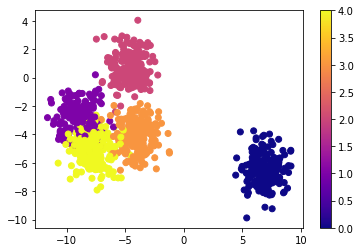

In [422]:
# 1) Dataset consisting of 1000  samples with  2  features and a column of labels. 

# Reading in hw6_data_1.npy
dat = np.load("../../homeworks/hw_data/hw6_data_1.npy")
# grab the first 2 columns of the data (the features) and the labels column
X, labels = dat[:,[0,1]], dat[:,2]

# formatter = plt.FuncFormatter(lambda i, *args: labels[int(i)])

# 2-D scatter plot of the data (feature1 vs feature2) colored by their labels
plt.scatter(X[:,0], X[:,1], c=labels, cmap='plasma')

plt.colorbar()
plt.show()

### (2) 

In [427]:
# 2) Determine the best bandwidth to use for kernel density estimation (KDE) 

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(X) #Fit the data.

h_opt = grid.best_params_['bandwidth']
print('Best bandwidth: ',h_opt)

Best bandwidth:  0.4724137931034482


/var/folders/8_/cx8t3z6n4c9ftpn96__x7z5c0000gq/T/ipykernel_34700/2992141640.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


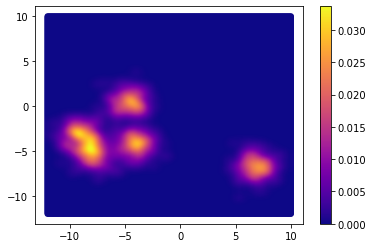

In [428]:
# Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution.
# Compute density with KDE
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt) 
kde.fit(X) #fit the model to the data

u = v = np.linspace(-12,10,200)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens_kde = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_kde, cmap="plasma", edgecolor="None")
plt.colorbar()
plt.show()

### (3) 

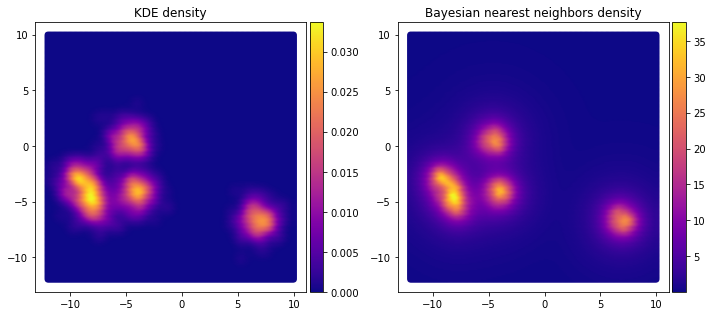

In [429]:
# 3) Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. 

from astroML.density_estimation import KNeighborsDensity

# Number of k neighbors needed to make the plot look similar to the KDE distribution
# obtained using trial and error
k = 80 

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X) 
dens_nbrs = nbrs.eval(Xgrid) 

# plot the results
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(1, 2, figsize=(10, 4.5))
im1 = ax[0].scatter(Xgrid[:,0], Xgrid[:,1], c=dens_kde, cmap="plasma", edgecolor="None")
ax[0].set_title('KDE density',fontsize=12)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, cmap="plasma", edgecolor="None")
ax[1].set_title('Bayesian nearest neighbors density',fontsize=12)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

### (4) 

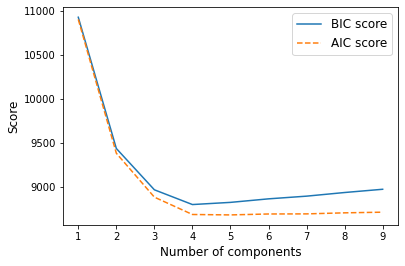

In [430]:
# 4) # Fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components 1-10

from sklearn.mixture import GaussianMixture

BIC,AIC = [],[]
for ii in range(1,10):
    gmm = GaussianMixture(ii)  # 'ii' is number of components
    gmm.fit(X)
    BIC.append(gmm.bic(X))
    AIC.append(gmm.aic(X))

# Plot these AIC and BIC values as a function of number of components
plt.plot(np.arange(1,10), BIC,label='BIC score')
plt.plot(np.arange(1,10), AIC, ls='--',label='AIC score')
plt.xlabel('Number of components',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.legend(fontsize=12)
plt.show()


In [363]:
# What is the optimal number according to the BIC? 
print('BIC: ',np.arange(1,10)[np.where(BIC==np.amin(BIC))[0][0]],' components/clusters are favored')
print('AIC: ',np.arange(1,10)[np.where(AIC==np.amin(AIC))[0][0]],' components/clusters are favored')

BIC:  4  components/clusters are favored
AIC:  5  components/clusters are favored


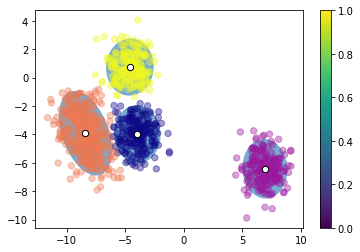

In [433]:
# Fit the data set with this optimal number of GMM components from BIC
gmm_optimal = GaussianMixture(4)
gmm_optimal.fit(X)

loc = gmm_optimal.means_ 
cov = gmm_optimal.covariances_

labels1 = gmm_optimal.predict(X)

# Plot the data set, the GMM component mean locations, and the 2-sigma GMM component ellipses
for j in range(0,4):
    # using given ellipse function 
    draw_ellipse(loc[j], cov[j], sigmas=[2], alpha=0.6) 
plt.scatter(X[:, 0], X[:, 1], c=labels1, cmap='plasma', s=40, alpha=0.4, zorder=1)
plt.scatter(loc[:, 0], loc[:, 1],s=40, c='w', edgecolors='k')
plt.colorbar()
plt.show()

### (5)

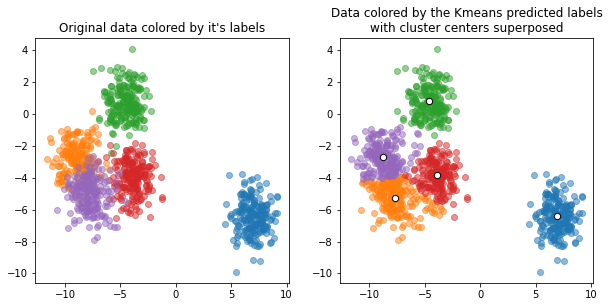

In [435]:
# 5) Now try Kmeans clustering with  5  clusters.
# Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, 
#       then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

# Kmeans clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Use the StandardScaler to scale the data.
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters=5) # Kmeans clustering with  5  clusters
clf.fit(scaler.fit_transform(X)) # fit the Kmeans model

centers = clf.cluster_centers_ # location of the cluster centers

cluster_centers = scaler.inverse_transform(centers) #inverse trans cluster centers back to original unscaled coords.

# predict labels for the scaled data
labels2 = clf.predict(scaler.fit_transform(X)) # Note to self: here, .fit_transform(X) is same as .transform(X)

# plot the data color-coded by cluster id

fig,ax = plt.subplots(1, 2, figsize=(10, 4.5))
colors = ['C0', 'C1', 'C2','C3', 'C4']

for jj in range(5):
    ax[0].scatter(X[:,0][labels==jj], X[:,1][labels==jj], color=colors[jj], alpha=0.5)
ax[0].set_title("Original data colored by it's labels",fontsize=12)
for ii in range(5):
    ax[1].scatter(X[labels2==ii,0], X[labels2==ii,1], color=colors[ii], alpha=0.5)
ax[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1],s=40, c='w', edgecolors='k')
ax[1].set_title("Data colored by the Kmeans predicted labels\nwith cluster centers superposed",fontsize=12)
plt.show()

---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [391]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

### (2)

In [436]:
# 2) Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to 2 features. 
# What is the explained variance of the data encapsulated in these eigen-features?

from sklearn.decomposition import PCA

# redifining this because I already have a variable named X in problem 1.
X1 = np.column_stack([data[key] for key in keylist]) 

pca = PCA(2, svd_solver='randomized')
pca.fit(X1)
evals = pca.explained_variance_ratio_
print('Expained variance of data encapsulated in the eigenvalues: ' + str(pca.explained_variance_))
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))


Expained variance of data encapsulated in the eigenvalues: [17.72913433  8.31598296]
Expained fractional variance of data encapsulated in the eigenvalues: [0.53320897 0.25010565]


### (3)

In [394]:
# 3) Access the 'type' key of the 'data' structure and make an array of labels out of these. 
# Do some research in astroML documentation to find out what these integer types correspond to, and state that here.

labels_arr = data['type']
print('The integer types ',np.amin(labels_arr),' and ',np.amax(labels_arr),' correspond to resolved and unresolved sources.')
print('Specifically, object type == 3 (galaxy) and type == 6 (star).')

# relevant websites:
# https://www.astroml.org/modules/generated/astroML.datasets.fetch_imaging_sample.html
# http://skyserver.sdss.org/dr8/en/help/browser/browser.asp?n=PhotoTag&t=U

The integer types  3  and  6  correspond to resolved and unresolved sources.
Specifically, object type == 3 (galaxy) and type == 6 (star).


### (4)

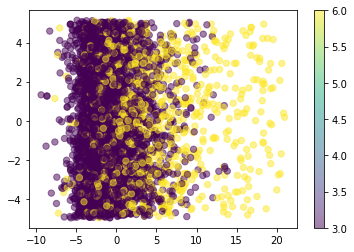

In [439]:
# 4) Choose  5000  random integers between 0 and the number of samples in the data matrix. 

ind = np.random.randint(X1.shape[0], size=5000) 

X5000 = X1[ind] # Record these integers because for later use
X_reduced = pca.transform(X5000)
np.shape(pca.transform(X5000))

# scatter plot of the PCA-reduced data for these  5000  random samples, colored by their corresponding type
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_arr[ind], cmap='viridis', s=40, alpha=0.5)
plt.colorbar()
plt.show()

In [ ]:
"""CAN LABEL AXES AS 'COMPRESSED FEATURES' OR SOMETHING SEE 47-ish """

### (5)

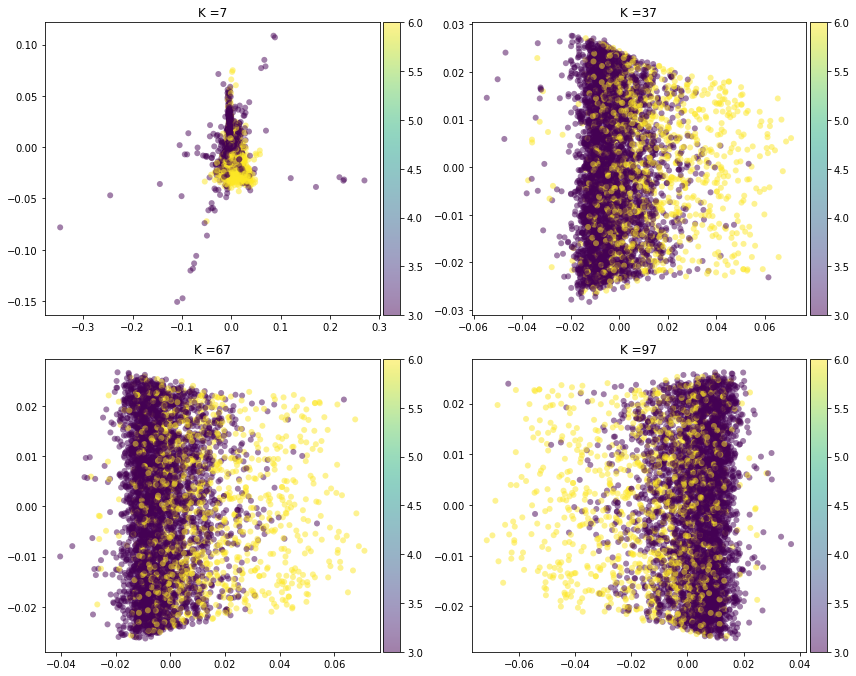

In [420]:
# 5) Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only 
# on the  5000  random samples identified in the previous part.

# Try LocallyLinearEmbedding, Isomap, and TSNE algorithms, setting the number of components to be 2 in all cases.

from sklearn.manifold import LocallyLinearEmbedding

# experiment with the number of nearest neighbors, k, between 5 and 100 to see what 
# visually gives the best separation in type populations.

k = [7,37,67,97] # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit


# As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their type
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9.5))
ax_arr = [ax1,ax2,ax3,ax4]

for i in range(len(k)):
    lle = LocallyLinearEmbedding(n_neighbors=k[i],n_components=n)
    lle.fit(X5000)
    X_reduced_lle = lle.transform(X5000)
    
    im = ax_arr[i].scatter(X_reduced_lle[:,0], X_reduced_lle[:,1],c=labels_arr[ind],cmap='viridis',
                           alpha=0.5,edgecolor="None")
    ax_arr[i].set_title('K ='+str(k[i]),fontsize=12)
    divider = make_axes_locatable(ax_arr[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
plt.tight_layout()
plt.show()

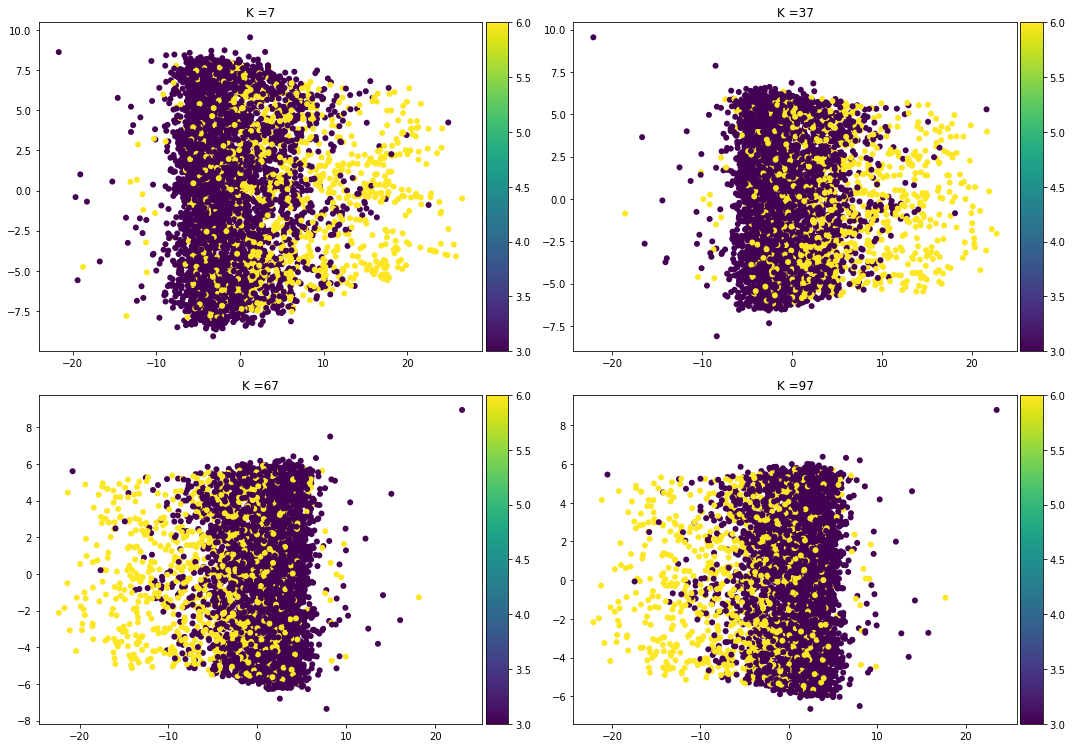

In [418]:
# Isomap

from sklearn.manifold import Isomap

# k = 7 # Number of neighbors to use in fit
# n = 2 # Number of dimensions to fit

# iso = Isomap(n_neighbors=k,n_components=n)
# iso.fit(X5000)

# X_reduced_iso = iso.transform(X5000)

# plt.scatter(X_reduced_iso[:,0], X_reduced_iso[:,1],c=labels_arr[ind],edgecolor="None")
# plt.colorbar()


# experiment with the number of nearest neighbors, k, between 5 and 100 to see what 
# visually gives the best separation in type populations.

k = [7,37,67,97] # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit

# Make scatter plots of the dimensionally-reduced data, color coded by their type. 
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9.5))
ax_arr = [ax1,ax2,ax3,ax4]

for i in range(len(k)):
    iso = Isomap(n_neighbors=k[i],n_components=n)
    iso.fit(X5000)
    X_reduced_iso = iso.transform(X5000)
    
    im = ax_arr[i].scatter(X_reduced_iso[:,0], X_reduced_iso[:,1],c=labels_arr[ind],cmap='viridis',
                           alpha=0.5,edgecolor="None")
    ax_arr[i].set_title('K ='+str(k[i]),fontsize=12)
    divider = make_axes_locatable(ax_arr[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


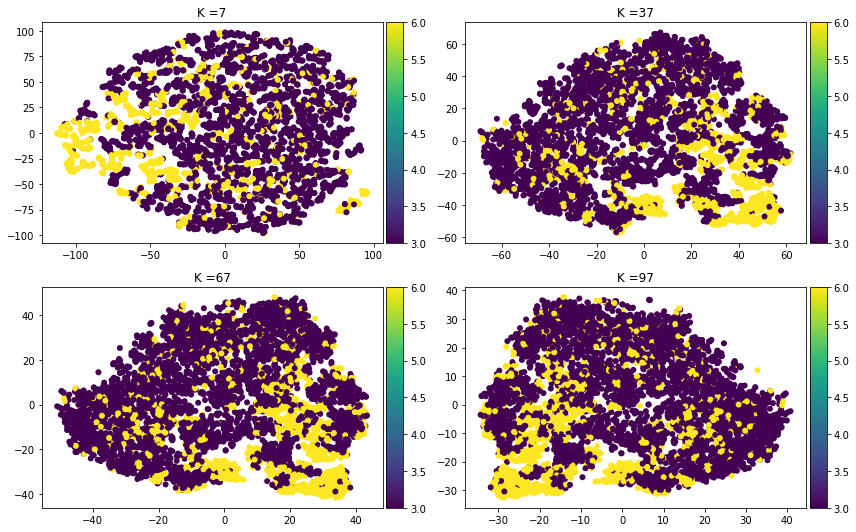

In [419]:
# TSNE

from sklearn.manifold import TSNE

# k = 95 # Number of neighbors to use in fit
# n = 2 # Number of dimensions to fit
# tsne = TSNE(n_components=n,perplexity=k,learning_rate=200)#
# X_reduced_tsne = tsne.fit_transform(X5000)

# plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=labels_arr[ind], alpha=0.3, edgecolor="None")
# plt.colorbar()
# plt.show()


# experiment with the preplexity attribute, k, between 5 and 100 to see what 
# visually gives the best separation in type populations.

k = [7,37,67,97] 
n = 2 # Number of dimensions to fit

# Make scatter plots of the dimensionally-reduced data, color coded by their type. 
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9.5))
ax_arr = [ax1,ax2,ax3,ax4]

for i in range(len(k)):
    tsne = TSNE(n_components=n,perplexity=k[i],learning_rate=200)#
    X_reduced_tsne = tsne.fit_transform(X5000)
    
    im = ax_arr[i].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=labels_arr[ind],cmap='viridis',
                           alpha=0.5,edgecolor="None")
    ax_arr[i].set_title('K ='+str(k[i]),fontsize=12)
    divider = make_axes_locatable(ax_arr[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:


# Which algorithm gives the cleanest way to visually see the two populations of sources? 
#      (This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)
